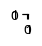

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.multimodal_datasets import MultimodalMarginalLatentDataset
from src.multimodal_models import BSSVAE, JMVAE
from src.multimodal_train_eval import predict_multimodal
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset



In [6]:
import networkx as nx

In [11]:
new_df_noswap = pd.read_csv('../data/multimodal/240326_nettcr_paired_NOswaps.csv')
new_df_wswap = pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv')
new_df_filt = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')

old_df_noswap = pd.read_csv('../data/filtered/240416_nettcr_old_26pep_no_swaps.csv')
old_df_wswap = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')

# fct defs

In [4]:
def get_latent_df(model, df, dataset_params:dict=None):
    
    # Init dataset and pred fct depending on model type
    dataset_params = dict(max_len_a1=7, max_len_a2=8, max_len_a3=22,
                          max_len_b1=6, max_len_b2=7, max_len_b3=23, max_len_pep=0,
                          encoding='BL50LO', pad_scale=-20,
                          a1_col='A1', a2_col='A2', a3_col='A3', b1_col='B1', b2_col='B2', b3_col='B3',
                          pep_col='peptide') if dataset_params is None else dataset_params
    
    if hasattr(model, 'vae'):
        model = model.vae
        if model.max_len>7+8+22+6+7+23:
            dataset_params['max_len_pep']=12
        else:
            dataset_params['max_len_pep']=0
            
    dataset_params['add_positional_encoding'] = model.add_positional_encoding

    if type(model) == FullTCRVAE:
        print(dataset_params)
        dataset = FullTCRDataset(df, **dataset_params)
        dataloader = dataset.get_dataloader(512, SequentialSampler)
        latent_df = predict_model(model, dataset, dataloader)
        
    elif type(model) in [BSSVAE, JMVAE]:
        pred_fct = predict_multimodal
        dataset_params['pair_only'] = True
        dataset_params['return_pair'] = type(model)==JMVAE
        dataset_params['modality']='tcr'
        dataset = MultimodalMarginalLatentDataset(model, df, **dataset_params)
        latent_df = df.copy()
        zdim = dataset.z.shape[1]
        latent_df[[f'z_{i}' for i in range(zdim)]] = dataset.z

    return latent_df

def get_distances_labels_from_latent(latent_df, label_col='peptide', seq_cols= ('A1','A2','A3','B1','B2','B3')):
    # Columns for making distmatrix
    rest_cols = list(x for x in latent_df.columns if x in ['peptide', 'original_peptide','origin', 'binder'])
    # Getting distmatrix and arrays
    dist_matrix = make_dist_matrix(latent_df, label_col, seq_cols, cols=rest_cols)
    dist_array = dist_matrix.iloc[:len(dist_matrix), :len(dist_matrix)].values
    # Getting label encoder and features for computing metrics
    features = latent_df[[z for z in latent_df.columns if z.startswith('z_')]].values
    label_encoder = LabelEncoder()
    labels = dist_matrix[label_col].values
    encoded_labels = label_encoder.fit_transform(labels)
    return dist_matrix, dist_array, features, labels, encoded_labels, label_encoder

def get_merged_distances_labels(dist_matrix, original_df, index_tcr_df, label_col='peptide', query_subset=None):
    # Assumes a square matrix with no other columns, and that the original_df and index_tcr_df match
    merged = pd.merge(index_tcr_df, original_df[[x for x in original_df.columns if x in['seq_id','peptide','partition','binder','origin','fulltcr']]],
         left_on=['q_index', 'tcr'], right_on=['seq_id','fulltcr'])
    
    assert((merged['seq_id']==merged['q_index']).all() and (merged['tcr']==merged['fulltcr']).all()),'fuck'
    merged = merged.set_index('q_index')[[x for x in merged.columns if x in ['peptide','partition','binder','origin']]]
    merged_dist_matrix = pd.merge(dist_matrix, merged, left_index=True,right_index=True)
    extra_cols = merged_dist_matrix.columns.difference(dist_matrix.columns)
    
    if query_subset is not None:
        query = merged_dist_matrix.query(query_subset)
        merged_dist_matrix = query[list(str(x) for x in query.index)+list(extra_cols)]
    
    return merged_dist_matrix, extra_cols

def get_distances_labels_from_distmatrix(dist_matrix, original_df, index_tcr_df, label_col='peptide', query_subset=None):
    merged_dist_matrix, extra_cols = get_merged_distances_labels(dist_matrix, original_df, index_tcr_df, label_col, query_subset)
    dist_array = merged_dist_matrix.iloc[:,:-len(extra_cols)].values
    features = torch.randn([dist_array.shape[0], 3])
    label_encoder = LabelEncoder()
    labels = merged_dist_matrix[label_col].values
    encoded_labels = label_encoder.fit_transform(labels)
    return merged_dist_matrix, dist_array, features, labels, encoded_labels, label_encoder

def cluster_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder,
                           decimals=5, n_points=1500):
    # Getting clustering at all thresholds
    limits = get_linspace(dist_array, decimals, n_points)
    results = []
    for t in tqdm(limits):
        c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
        c.fit(dist_array)
        results.append(get_all_metrics(t, features, c, dist_array, labels, encoded_labels, label_encoder))
    results = pd.DataFrame(results)
    results['retention'] = (dist_array.shape[0]-results['n_singletons']) / dist_array.shape[0]
    return results

In [5]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score as ch_score, davies_bouldin_score as db_score, adjusted_rand_score
def get_model(folder, map_location='cpu'):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, map_location='cpu')
    # Extract the vae part if the model comes from a two stage VAE
    if type(model)==TwoStageVAECLF:
        model = model.vae
    model.eval()
    return model


def get_purity(counts):
    # Purity in absolute % of a cluster, taking the majority label 
    # high = better
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    return sorted_counts[list(sorted_counts.keys())[0]] / sum(sorted_counts.values())
    
def get_mixity(counts):
    # how many different labels are inside a cluster, weighted by the number of members
    # low = better
    return len(counts.keys()) / sum(counts.values())
    
def get_coherence(dist_array):
    # Assumes dist_array is the subset of the distance array for a given cluster label
    # mean distance within a cluster
    # low = better

    # get upper triangle mask without the diagonale
    mask = np.triu(np.ones(dist_array.shape), k=0) - np.eye(dist_array.shape[0])
    flat_array = dist_array[mask==1]
    return np.mean(flat_array)

def get_purity_mixity_coherence(cluster_label:int, 
                                true_labels:list, 
                                pred_labels:list, 
                                dist_array:np.array,
                                label_encoder):
    """
        For a given cluster label (int) returned by clustering.labels_, 
        Return the purity, mixity, coherence, cluster_size, and scale (==cluster_size/total_size)
        scale should be used to get a weighted average metric at the end
    """
    indices = np.where(pred_labels==cluster_label)[0]
    cluster_size = len(indices)
    if cluster_size<=1:
        # return np.nan, np.nan, np.nan, 1, 1/len(true_labels)
        return {'purity':np.nan, 'coherence':np.nan, 'cluster_size':1}

    # Query the subset of the true labels belonging to this cluster using indices 
    # Convert to int label encodings in order to use np.bincount to get purity and mixity
    subset = true_labels[indices]
    encoded_subset = label_encoder.transform(subset)
    counts = {i:k for i,k in enumerate(np.bincount(encoded_subset)) if k>0}
    purity = get_purity(counts)
    # mixity = get_mixity(counts)
    # index the distance matrix and return the mean distance within this cluster (i.e. coherence)
    coherence = get_coherence(dist_array[indices][:, indices])
    
    # return purity, mixity, coherence, cluster_size, cluster_size / len(true_labels)
    return {'purity':purity, 'coherence':coherence, 'cluster_size':cluster_size}

def get_all_metrics(t, features, c, array, true_labels, encoded_labels, label_encoder, return_df=False):
    n_cluster = np.sum((np.bincount(c.labels_)>1))
    n_singletons = (np.bincount(c.labels_)==1).sum()
    try:
        s_score = silhouette_score(array, c.labels_, metric='precomputed')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan
    
    xd = pd.concat([pd.DataFrame(get_purity_mixity_coherence(k, true_labels, c.labels_, array, label_encoder), index=[0]).assign(pred_label=k)
                    for k in set(c.labels_)])
    mean_purity = xd['purity'].dropna().mean()
    mean_coherence = xd['coherence'].dropna().mean()
    mean_cs = xd['cluster_size'].dropna().mean()
    nc_07 = len(xd.dropna().query('purity>=0.7'))
    metrics = {'threshold':t, 
            'n_cluster':n_cluster, 'n_singletons':n_singletons,
            'n_cluster_over_70p':nc_07,
            'mean_purity':xd.dropna()['purity'].mean(), 
            'min_purity':xd.dropna()['purity'].min(), 
            'max_purity':xd.dropna()['purity'].max(), 
            'mean_coherence':xd.dropna()['coherence'].mean(), 
            'min_coherence':xd.dropna()['coherence'].min(), 
            'max_coherence':xd.dropna()['coherence'].max(), 
            'mean_cluster_size': xd.dropna()['cluster_size'].mean(),
            'min_cluster_size': xd.dropna()['cluster_size'].min(),
            'max_cluster_size': xd.dropna()['cluster_size'].max(),
            'silhouette':s_score,
            'ch_index':c_score, 'db_index':d_score, 'ARI':ari_score}
    if return_df :
        return metrics, xd
    else:
        return metrics

def get_bounds(array, decimals=5):
    lower_bound = array[array>0].min()
    upper_bound = array.max()
    factor = 10 ** decimals
    return np.floor(lower_bound * factor)/factor, np.ceil(upper_bound*factor)/factor


def get_linspace(array, decimals=5, n_points=1500):
    return np.round(np.linspace(*get_bounds(array, decimals), n_points), decimals)

In [6]:
def plot_curve_clustersizes(run, filter=None):
    if filter is None:
        filter = run.input_type.unique()
    else:
        if ['TBCRalign'] not in filter:
            filter = ['TBCRalign']+filter
        if ['tcrdist3'] not in filter:
            filter = ['tcrdist3']+filter
            
    sns.set_palette('gnuplot2', n_colors=len(filter)-2)
    f,a = plt.subplots(1, 1, figsize=(13,9))
    a.set_xlim([0,1])
    a.set_ylim([0,1])
    a.set_xlabel('Retention', fontweight='semibold', fontsize=14)
    a.set_ylabel('Avg Purity', fontweight='semibold', fontsize=14)
    # Setting major ticks
    major_ticks = np.arange(0, 1.1, 0.1)
    a.set_xticks(major_ticks)
    a.set_yticks(major_ticks)
    # Setting minor ticks
    minor_ticks = np.arange(0, 1.1, 0.05)
    a.set_xticks(minor_ticks, minor=True)
    a.set_yticks(minor_ticks, minor=True)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    ax2 = a.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_yscale('log', base=2)
    
    markers = ['*', '.', '+', 'h', 's', '3', 'v', 'o', 'x', 'p']
    print(len(filter))
    for i,input_type in enumerate(filter):
        query = run.query('input_type==@input_type')
        retentions = query['retention'].values
        purities = query['mean_purity'].values
        clustersizes = query['mean_cluster_size']
        if input_type=="TBCRalign":
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls='-.', c='g', lw=1.)
            ax2.scatter(retentions, clustersizes, label=input_type.lstrip('_'), marker='x', lw=0.5, s=8, c='g')
        elif input_type=="tcrdist3":
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls='-.', c='y', lw=1.)
            ax2.scatter(retentions, clustersizes, label=input_type.lstrip('_'), marker='v', lw=0.1, s=8, c='y')
        else:
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls='--', lw=1.)
            ax2.scatter(retentions, clustersizes, label=input_type.lstrip('_'), marker='+', lw=1.15, s=12)
        
    a.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
    a.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
    a.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')
    
    a.legend(title='distance matrix', bbox_to_anchor=(1.1, 0.85),
             title_fontproperties={'size':14, 'weight':'semibold'}, prop={'weight':'semibold','size':12})
    
    ax2.legend(title='Mean cluster size', bbox_to_anchor=(1.1, 0.35),
             title_fontproperties={'size':14, 'weight':'semibold'}, prop={'weight':'semibold','size':12})
    
    f.tight_layout()

In [7]:
from sklearn.metrics import auc

def vae_clustering_pipeline(model_folder, input_df, name, dataset_params=None, n_points=500):
    model = get_model(model_folder, map_location='cpu')
    latent_df = get_latent_df(model, input_df, dataset_params)
    dist_matrix, dist_array, features, labels, encoded_labels, label_encoder = get_distances_labels(latent_df)
    results = cluster_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder, n_points=n_points)
    results['input_type'] = name
    return results

def plot_pipeline(results, b, plot_title = 'None', fig_fn = None, filter=None, palette=None, more=False, add_cluster_size=False):
    runs = pd.concat([b, results])
    # plotting options
    if filter is None:
        filter = ['TBCRalign', 'KernelSim', 'tcrdist3'] + list(results.input_type.unique())

    if palette is None:
        palette='gnuplot2'
    if more:
        palette = get_palette(palette, n_colors=len(filter)-3)
    else:
        palette = sns.color_palette(palette, n_colors=len(filter)-3)

    sns.set_palette(palette)
    f,a = plt.subplots(1, 1, figsize=(9,9))
    a.set_xlim([0,1])
    a.set_ylim([0,1])
    a.set_xlabel('Retention', fontweight='semibold', fontsize=14)
    a.set_ylabel('Avg Purity', fontweight='semibold', fontsize=14)
    # Setting major ticks
    major_ticks = np.arange(0, 1.1, 0.1)
    a.set_xticks(major_ticks)
    a.set_yticks(major_ticks)
    # Setting minor ticks
    minor_ticks = np.arange(0, 1.1, 0.05)
    a.set_xticks(minor_ticks, minor=True)
    a.set_yticks(minor_ticks, minor=True)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    print(runs.duplicated().any())
    if add_cluster_size:
        ax2 = a.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_yscale('log', base=2)
        
    for i, input_type in enumerate(filter):
        query = runs.query('input_type==@input_type')
        retentions = query['retention'].values[1:-1]
        purities = query['mean_purity'].values[1:-1]
        print(input_type, '\t', round(get_retpur_auc(retentions, purities),4))
        ls = '-' if i%2==0 else '--'
        if add_cluster_size:
            cluster_sizes = query['mean_cluster_size'].values[1:-1]
        # Plotting baselines with fixed styles colors etc
        if input_type=="TBCRalign":
            a.plot(retentions, purities, label='TBCRalign', ls=':', c='k', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='x', lw=0.5, s=8, c='k')
        elif input_type=="KernelSim":
            a.plot(retentions, purities, label='KernelSim', ls=':', c='m', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='v', lw=0.1, s=8, c='m')
        elif input_type=="tcrdist3":
            a.plot(retentions, purities, label='tcrdist3', ls=':', c='y', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='*', lw=0.1, s=8, c='y')
        # Plotting the actual things
        else:
            a.plot(retentions, purities, label=input_type.lstrip('_').replace('_',' ').replace('checkpoint best',''), ls=ls, lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='+', lw=1.15, s=12)
        
    a.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
    a.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
    a.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')
    
    a.legend(title='distance matrix', title_fontproperties={'size':14, 'weight':'semibold'}, prop={'weight':'semibold','size':12})

    

    
    f.suptitle(f'{plot_title}', fontweight='semibold', fontsize=15)
    f.tight_layout()
    if fig_fn is not None:
        f.savefig(f'../output/240411_ClusteringTests/{fig_fn}.png', dpi=200)
    return runs
    
def get_retpur_auc(retentions, purities):
    return auc(retentions, purities)
 
def plot_pipeline(results, b, plot_title = 'None', f=None, ax=None, fig_fn = None, filter=None, palette=None, more=False, add_cluster_size=False):
    runs = pd.concat([b, results])
    # plotting options
    if filter is None:
        filter = ['TBCRalign', 'KernelSim', 'tcrdist3'] + list(results.input_type.unique())

    if palette is None:
        palette='gnuplot2'
    if more:
        palette = get_palette(palette, n_colors=len(filter)-3)
    else:
        palette = sns.color_palette(palette, n_colors=len(filter)-3)

    sns.set_palette(palette)
    if f is None and ax is None:
        f,ax = plt.subplots(1, 1, figsize=(9,9))
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('Retention', fontweight='semibold', fontsize=14)
    ax.set_ylabel('Avg Purity', fontweight='semibold', fontsize=14)
    # Setting major ticks
    major_ticks = np.arange(0, 1.1, 0.1)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    # Setting minor ticks
    minor_ticks = np.arange(0, 1.1, 0.05)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    print(runs.duplicated().any())
    if add_cluster_size:
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_yscale('log', base=2)
        
    for i, input_type in enumerate(filter):
        query = runs.query('input_type==@input_type')
        retentions = query['retention'].values[1:-1]
        purities = query['mean_purity'].values[1:-1]
        try:
            print(input_type, '\t', round(get_retpur_auc(retentions, purities),4))
        except:
            print(input_type)
        ls = '-' if i%2==0 else '--'
        if add_cluster_size:
            cluster_sizes = query['mean_cluster_size'].values[1:-1]
        # Plotting baselines with fixed styles colors etc
        if input_type=="TBCRalign":
            ax.plot(retentions, purities, label='TBCRalign', ls=':', c='k', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='x', lw=0.5, s=8, c='k')
        elif input_type=="KernelSim":
            ax.plot(retentions, purities, label='KernelSim', ls=':', c='m', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='v', lw=0.1, s=8, c='m')
        elif input_type=="tcrdist3":
            ax.plot(retentions, purities, label='tcrdist3', ls=':', c='y', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='*', lw=0.1, s=8, c='y')
        # Plotting the actual things
        else:
            ax.plot(retentions, purities, label=input_type.lstrip('_').replace('_',' ').replace('checkpoint best',''), ls=ls, lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='+', lw=1.15, s=12)
        
    ax.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
    ax.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
    ax.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')
    
    ax.legend(title='distance matrix', title_fontproperties={'size':14, 'weight':'semibold'}, prop={'weight':'semibold','size':12})

    

    
    f.suptitle(f'{plot_title}', fontweight='semibold', fontsize=15)
    f.tight_layout()
    if fig_fn is not None:
        f.savefig(f'../output/240411_ClusteringTests/{fig_fn}.png', dpi=200)
    return runs

In [8]:
def pipeline_best_model_clustering(model, input_df, name, n_points=500):
    # Assuming we are using VAE based models 
    if type(model)==str:
        model = get_model(model_folder, map_location='cpu')
    latent_df = get_latent_df(model, input_df)
    print(len(latent_df))
    dist_matrix, dist_array, features, labels, encoded_labels, label_encoder = get_distances_labels_from_latent(latent_df)
    results = cluster_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder, n_points=n_points)
    results['input_type'] = name
    return results
    
# Here, do a run ith only the best

# Prune dataset based on TCRBase results

In [77]:
from sklearn.metrics import roc_auc_score
from src.metrics import get_metrics
def read_tcrbase_results_old(peptide, original_df, partition=0, dir_='../output/TCRBASE/tcrbase_old_ALL_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir_}{peptide}.txt', comment='#', sep='\s', header=None, names=cols)
    df['q_seq'] = df.apply(lambda x: ''.join([x[f'q_{c}'] for c in ['A1','A2','A3','B1','B2','B3']]), axis=1)
    original_df = original_df.query(f'peptide=="{peptide.split("_")[0]}" and partition==@partition')

    original_df['q_seq'] = original_df.apply(lambda x: ''.join([x[c] for c in ['A1','A2','A3','B1','B2','B3']]), axis=1)
    results = pd.merge(df.set_index('q_seq')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       original_df.set_index('q_seq')[['partition','binder', 'peptide', 'A1','A2','A3','B1','B2','B3']],
                       left_index=True, right_index=True)
    print(peptide, round(roc_auc_score(results['binder'], results['score']),4))
    tcrbase_metrics = {'peptide':peptide, 
                       'method':'tcrbase',
                       'n_pos':len(original_df.query('original_peptide==@peptide and partition==0'))}
    tcrbase_metrics.update(get_metrics(results['binder'], results['score'], round_digit=5))

    return tcrbase_metrics, results

def read_tcrbase_results_exp(peptide, original_df, dir='../output/TCRBASE/tcrbase_expanded_p0_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir}{peptide}.txt', comment='#', sep='\s', header=None, names=cols)
    results = pd.merge(df.set_index('id_query')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       original_df[['binder', 'peptide', 'A1','A2','A3','B1','B2','B3']],
                       left_index=True, right_index=True)
    print(peptide, round(roc_auc_score(results['binder'], results['score']),4))
    tcrbase_metrics = {'peptide':peptide, 
                       'method':'tcrbase',
                       'n_pos':len(original_df.query('original_peptide==@peptide and partition==0'))}
    tcrbase_metrics.update(get_metrics(results['binder'], results['score'], round_digit=5))
    print(tcrbase_metrics)
    return tcrbase_metrics, results


In [78]:
# Remove peptides below a certain TCRBase AUC ; Based on the old dataset 
tcrbase_old = pd.DataFrame([read_tcrbase_results_old(f'{p}_p0', old_df_wswap, 0)[0] for p in old_df.peptide.unique()])
tcrbase_old['peptide']=tcrbase_old['peptide'].apply(lambda x: x.replace('_p0', ''))
to_remove_old = tcrbase_old.query('auc_01<0.6').peptide.values

RFPLTFGWCF_p0 0.8314
GILGFVFTL_p0 0.803
KLGGALQAK_p0 0.5518
DATYQRTRALVR_p0 0.7622
RAKFKQLL_p0 0.8868
ELAGIGILTV_p0 0.9001
GLCTLVAML_p0 0.8821
AVFDRKSDAK_p0 0.5317
SPRWYFYYL_p0 0.6803
ATDALMTGF_p0 0.7735
IVTDFSVIK_p0 0.6719
SLFNTVATLY_p0 0.5789
HPVTKYIM_p0 0.8576
YLQPRTFLL_p0 0.8747
RLPGVLPRA_p0 0.6925
FEDLRLLSF_p0 0.5968
CINGVCWTV_p0 0.7465
KSKRTPMGF_p0 0.8983
FEDLRVLSF_p0 0.6087
GPRLGVRAT_p0 0.7917
NLVPMVATV_p0 0.5637
VLFGLGFAI_p0 0.8756
LLWNGPMAV_p0 0.8518
RPPIFIRRL_p0 0.8148
CTELKLSDY_p0 0.8458
RLRAEAQVK_p0 0.4745


In [79]:
# Remove peptides below a certain TCRBase AUC ; Based on the old dataset 
tcrbase_exp = pd.DataFrame([read_tcrbase_results_exp(p, new_df_wswap)[0] for p in new_df_wswap.peptide.unique()])
tcrbase_exp['peptide']=tcrbase_exp['peptide'].apply(lambda x: x.replace('_p0', ''))
to_remove_exp = tcrbase_exp.query('auc_01<0.6').peptide.values

AVFDRKSDAK 0.4855
{'peptide': 'AVFDRKSDAK', 'method': 'tcrbase', 'n_pos': 752, 'auc': 0.48551, 'auc_01': 0.50745, 'auc_01_real': 0.06416, 'precision': 0.16628, 'recall': 1.0, 'accuracy': 0.16628, 'AP': 0.18505}
KLGGALQAK 0.6103
{'peptide': 'KLGGALQAK', 'method': 'tcrbase', 'n_pos': 1130, 'auc': 0.6103, 'auc_01': 0.55241, 'auc_01_real': 0.14958, 'precision': 0.16728, 'recall': 1.0, 'accuracy': 0.16728, 'AP': 0.29468}
ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 502, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall': 1.0, 'accuracy': 0.16758, 'AP': 0.80004}
TTDPSFLGRY 0.6819
{'peptide': 'TTDPSFLGRY', 'method': 'tcrbase', 'n_pos': 535, 'auc': 0.68187, 'auc_01': 0.61969, 'auc_01_real': 0.27741, 'precision': 0.16774, 'recall': 1.0, 'accuracy': 0.16774, 'AP': 0.44064}
RAKFKQLL 0.8805
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 945, 'auc': 0.88051, 'auc_01': 0.80623, 'auc_01_real': 0.63184, 'precision': 0.16667, 're

In [88]:
old_pruned_wswap = old_df_wswap.query('peptide not in @to_remove_old')
old_pruned_noswap = old_df_noswap.query('peptide not in @to_remove_old')
new_pruned_wswap = new_df_wswap.query('peptide not in @to_remove_exp')
new_pruned_noswap = new_df_noswap.query('peptide not in @to_remove_exp')

In [96]:
# FOR TCRBASE: THE NON-PRUNED VERSION SHOULD BE USED FOR THE QUERY!
old_pruned_wswap.to_csv('../data/filtered/240507_nettcr_old_pruned_wswap_20peps.csv')
old_pruned_noswap.to_csv('../data/filtered/240507_nettcr_old_pruned_noswap_20peps.csv')
new_pruned_wswap.to_csv('../data/filtered/240507_nettcr_exp_pruned_wswap_78peps.csv')
new_pruned_noswap.to_csv('../data/filtered/240507_nettcr_exp_pruned_noswap_78peps.csv')

In [101]:
tcrbase_old.query('peptide=="RPPIFIRRL"')

,peptide,method,n_pos,auc,auc_01,auc_01_real,precision,recall,accuracy,AP
23,RPPIFIRRL,tcrbase,0,0.81481,0.73684,0.5,0.14286,1.0,0.14286,0.64833


In [104]:
below_50_pep = old_pruned_noswap.groupby('peptide').agg(count=('B3','count')).query('count<=50').index
tcrbase_old.query("peptide in @below_50_pep")

,peptide,method,n_pos,auc,auc_01,auc_01_real,precision,recall,accuracy,AP
14,RLPGVLPRA,tcrbase,0,0.69251,0.69400,0.41860,0.17308,1.0,0.17308,0.56772
18,FEDLRVLSF,tcrbase,0,0.60870,0.68421,0.40000,0.17857,1.0,0.17857,0.52989
19,GPRLGVRAT,tcrbase,0,0.79167,0.77851,0.57917,0.17241,1.0,0.17241,0.70666
21,VLFGLGFAI,tcrbase,0,0.87558,0.84962,0.71429,0.18421,1.0,0.18421,0.80952
23,RPPIFIRRL,tcrbase,0,0.81481,0.73684,0.50000,0.14286,1.0,0.14286,0.64833
24,CTELKLSDY,tcrbase,0,0.84583,0.71491,0.45833,0.17241,1.0,0.17241,0.64817


In [94]:
len(old_pruned_noswap), len(new_pruned_noswap)

(4289, 6955)

# Custom sampler

In [452]:
math.ceil(len(df)/1024)

6

In [455]:
from src.datasets import TCRSpecificDataset
from tqdm.auto import tqdm
# from pprint import pprint
## first check that my current implementation with batch_sizes of 512 or 1024 really leaves some classes by themselves

df = old_pruned_noswap.query('partition!=0').copy()
pepmap = {k: v for v, k in enumerate(df[pep_col].unique())} # FIX

dataset_params = dict(max_len_a1=7, max_len_a2=8, max_len_a3=22, 
                      max_len_b1=6, max_len_b2=7, max_len_b3=23,
                      a1_col='A1', a2_col='A2', a3_col='A3', 
                      b1_col='B1', b2_col='B2', b3_col='B3', pep_col='peptide', pep_weighted=False)
dataset = TCRSpecificDataset(df, **dataset_params)
minimum_size=50
low_number = df.groupby('peptide').agg(count=('B3','count')).query('count<=@minimum_size').index

df['minority_class'] = df['peptide'].apply(lambda x: x in low_number)
minority_classes = [pepmap[x] for x in df.query('minority_class').peptide.unique()]
loader_512 = dataset.get_dataloader(512, RandomSampler)
loader_1024 = dataset.get_dataloader(1024, RandomSampler)

sum_minority_512 = {m:0 for m in minority_classes}
sum_minority_1024 = {m:0 for m in minority_classes}
n_epochs = 1000
for _ in tqdm(range(n_epochs)):
    labels_512 = [x[1] for x in loader_512]
    labels_1024 = [x[1] for x in loader_1024]
    minority_512 = {m:len(torch.where(torch.tensor([len(torch.where(x==m)[0]) for x in labels_512])==1)[0]) for m in minority_classes}
    minority_1024 = {m:len(torch.where(torch.tensor([len(torch.where(x==m)[0]) for x in labels_1024])==1)[0]) for m in minority_classes}
    for m in minority_classes:
        sum_minority_512[m] +=minority_512[m]
        sum_minority_1024[m] +=minority_1024[m]

print(f'After {n_epochs} epochs: in old pruned dataset (n={len(df)})\nSum of number of batches containing a single instance of a given minority class (count<{minimum_size}):')
print(f'\nBatch size = 512 ; total batches (n_epochs * n_batch) {n_epochs * math.ceil(len(df)/512)} \n\t')
for k,v in sum_minority_512.items():
    print({v:k for k,v in pepmap.items()}[k], v, f'{(v / (n_epochs * math.ceil(len(df)/512))):.3%} of all batches')
print(f'\nBatch size = 1024 ; total batches (n_epochs * n_batch) {n_epochs * math.ceil(len(df)/1024)}\n\t')
for k,v in sum_minority_1024.items():
    print({v:k for k,v in pepmap.items()}[k], v, f'{(v / (n_epochs * math.ceil(len(df)/1024))):.3%} of all batches')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.23it/s]

After 1000 epochs: in old pruned dataset (n=3429)
Sum of number of batches containing a single instance of a given minority class (count<50):

Batch size = 512 ; total batches (n_epochs * n_batch) 7000 
	
RFPLTFGWCF 99 1.414% of all batches
HPVTKYIM 97 1.386% of all batches
YLQPRTFLL 43 0.614% of all batches
GPRLGVRAT 161 2.300% of all batches
VLFGLGFAI 702 10.029% of all batches
FEDLRVLSF 1328 18.971% of all batches
RPPIFIRRL 353 5.043% of all batches
CTELKLSDY 149 2.129% of all batches
RLPGVLPRA 226 3.229% of all batches

Batch size = 1024 ; total batches (n_epochs * n_batch) 4000
	
RFPLTFGWCF 62 1.550% of all batches
HPVTKYIM 49 1.225% of all batches
YLQPRTFLL 25 0.625% of all batches
GPRLGVRAT 69 1.725% of all batches
VLFGLGFAI 195 4.875% of all batches
FEDLRVLSF 305 7.625% of all batches
RPPIFIRRL 134 3.350% of all batches
CTELKLSDY 68 1.700% of all batches
RLPGVLPRA 80 2.000% of all batches


In [456]:
from src.datasets import TCRSpecificDataset
from tqdm.auto import tqdm
# from pprint import pprint
## first check that my current implementation with batch_sizes of 512 or 1024 really leaves some classes by themselves

df = new_pruned_noswap.query('partition!=0').copy()
pepmap = {k: v for v, k in enumerate(df[pep_col].unique())} # FIX

dataset_params = dict(max_len_a1=7, max_len_a2=8, max_len_a3=22, 
                      max_len_b1=6, max_len_b2=7, max_len_b3=23,
                      a1_col='A1', a2_col='A2', a3_col='A3', 
                      b1_col='B1', b2_col='B2', b3_col='B3', pep_col='peptide', pep_weighted=False)
dataset = TCRSpecificDataset(df, **dataset_params)
minimum_size=50
low_number = df.groupby('peptide').agg(count=('B3','count')).query('count<=@minimum_size').index

df['minority_class'] = df['peptide'].apply(lambda x: x in low_number)
minority_classes = [pepmap[x] for x in df.query('minority_class').peptide.unique()]
loader_512 = dataset.get_dataloader(512, RandomSampler)
loader_1024 = dataset.get_dataloader(1024, RandomSampler)

sum_minority_512 = {m:0 for m in minority_classes}
sum_minority_1024 = {m:0 for m in minority_classes}
n_epochs = 1000
for _ in tqdm(range(n_epochs)):
    labels_512 = [x[1] for x in loader_512]
    labels_1024 = [x[1] for x in loader_1024]
    minority_512 = {m:len(torch.where(torch.tensor([len(torch.where(x==m)[0]) for x in labels_512])==1)[0]) for m in minority_classes}
    minority_1024 = {m:len(torch.where(torch.tensor([len(torch.where(x==m)[0]) for x in labels_1024])==1)[0]) for m in minority_classes}
    for m in minority_classes:
        sum_minority_512[m] +=minority_512[m]
        sum_minority_1024[m] +=minority_1024[m]

print(f'After {n_epochs} epochs: in old pruned dataset (n={len(df)})\nSum of number of batches containing a single instance of a given minority class (count<{minimum_size}):')
print(f'\nBatch size = 512 ; total batches (n_epochs * n_batch) {n_epochs * math.ceil(len(df)/512)} \n\t')
for k,v in sum_minority_512.items():
    print({v:k for k,v in pepmap.items()}[k], v, f'{(v / (n_epochs * math.ceil(len(df)/512))):.3%} of all batches')
print(f'\nBatch size = 1024 ; total batches (n_epochs * n_batch) {n_epochs * math.ceil(len(df)/1024)}\n\t')
for k,v in sum_minority_1024.items():
    print({v:k for k,v in pepmap.items()}[k], v, f'{(v / (n_epochs * math.ceil(len(df)/1024))):.3%} of all batches')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.13it/s]

After 1000 epochs: in old pruned dataset (n=5561)
Sum of number of batches containing a single instance of a given minority class (count<50):

Batch size = 512 ; total batches (n_epochs * n_batch) 11000 
	
LLDFVRFMGV 3832 34.836% of all batches
RPRGEVRFL 3990 36.273% of all batches
SVYGDTLEK 3512 31.927% of all batches
ALWEIQQVV 3043 27.664% of all batches
VSDGGPNLY 3655 33.227% of all batches
RFPLTFGWCF 1061 9.645% of all batches
EAAGIGILTV 3881 35.282% of all batches
FEDLRVLSF 3845 34.955% of all batches
FEDLRVSSF 3620 32.909% of all batches
LPRWYFYYL 3204 29.127% of all batches
HPVTKYIM 831 7.555% of all batches
MTLHGHMMY 4243 38.573% of all batches
GPRLGVRAT 1018 9.255% of all batches
QELIRQGTDY 3993 36.300% of all batches
KLWAQCVQL 3477 31.609% of all batches
FLYALALLL 3410 31.000% of all batches
FTSDYYQLY 1638 14.891% of all batches
CLGGLLTMV 4133 37.573% of all batches
HTMLCMCCK 4214 38.309% of all batches
FEDLRLLSF 3065 27.864% of all batches
NYNYLYRLF 881 8.009% of all batches

In [468]:
low = old_pruned_noswap.groupby('peptide').agg(count=('B3','count')).query('count<=50').index
old_pruned_noswap.query('peptide in @low').groupby('peptide').agg(count=('B3','count')).sum()

count    229
dtype: int64

In [474]:
len(x)

13

In [478]:
len(low_number)

60

In [481]:
# x = torch.arange(0, 60, 1)
from copy import deepcopy
minority_classes = deepcopy(low_number)
batch_size = 512
n_batches = math.ceil(len(df)/batch_size)
n_classes_to_pick = math.ceil(len(minority_classes)/n_batches)
for i in range(n_batches):
    selected = minority_classes[:min(n_classes_to_pick, len(minority_classes))]
    minority_classes = minority_classes[n_classes_to_pick:]
    print(f'epoch:{i}, num_selected {len(selected)}, num_remaining{len(minority_classes)}')

epoch:0, num_selected 6, num_remaining54
epoch:1, num_selected 6, num_remaining48
epoch:2, num_selected 6, num_remaining42
epoch:3, num_selected 6, num_remaining36
epoch:4, num_selected 6, num_remaining30
epoch:5, num_selected 6, num_remaining24
epoch:6, num_selected 6, num_remaining18
epoch:7, num_selected 6, num_remaining12
epoch:8, num_selected 6, num_remaining6
epoch:9, num_selected 6, num_remaining0
epoch:10, num_selected 0, num_remaining0


In [392]:
from torch.utils.data import Sampler
from itertools import cycle, islice
df = new_pruned_noswap.query('partition!=0').copy()
pep_col = 'peptide'
pepmap = {k: v for v, k in enumerate(df[pep_col].unique())} # FIX
labels = torch.from_numpy(df[pep_col].map(pepmap).values)
minimum_size=25
low_number = df.groupby('peptide').agg(count=('B3','count')).query('count<=@minimum_size').index
df['minority_class'] = df['peptide'].apply(lambda x: x in low_number)
minority_classes = [pepmap[x] for x in df.query('minority_class').peptide.unique()]
non_minority_classes = [pepmap[x] for x in df.query('not minority_class').peptide.unique()]
class_indices = {cls: np.where(labels == cls)[0] for cls in minority_classes}

# Extend minority indices to ensure they can fill many batches
extended_minority_indices = np.hstack([class_indices[cls] for cls in minority_classes])
np.random.shuffle(extended_minority_indices)
minority_indices_cycle = cycle(extended_minority_indices)
mcs = torch.tensor(minority_classes)
batch_size = 512

num_batches = math.ceil(len(labels)/batch_size)
class_per_batch = math.ceil(len(mcs)/num_batches)
len(mcs), num_batches, len(labels), class_per_batch

(54, 11, 5561, 5)

In [387]:
batch_size=1024
num_batches = math.ceil(len(labels)/batch_size)
math.ceil(61/num_batches), num_batches

(11, 6)

In [391]:
x = [ 0,  9, 10, 11, 14, 15, 16, 18, 19]
x.pop([0, 9, 10])
x

TypeError: pop expected at most 1 argument, got 3

In [389]:
60%num_batches

0

In [208]:
mcs = torch.tensor(minority_classes)
mcs, mcs[torch.randperm(len(mcs))]

(tensor([ 0,  9, 10, 11, 14, 15, 16, 18, 19]),
 tensor([14,  9, 15, 10, 16, 19, 18, 11,  0]))

In [537]:
x=torch.randint(0,5,[10])
x.fill_(3)
x

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [558]:
class MinorityClassSampler(Sampler):
    """
        Custom Superclass to handle saving labels, minority classes, pepmap, indices as attributes as well as a counter
    """

    def __init__(self, labels, batch_size, minority_classes):
        super(MinorityClassSampler, self).__init__(labels)
        # self.pepmap = pepmap
        # self.inverse_pepmap = {v: k for k, v in pepmap.items()}
        self.labels = torch.tensor(labels)
        self.minority_classes = torch.tensor(minority_classes)
        self.n_minorities = len(minority_classes)
        self.non_minority_classes = torch.tensor(
            [cls for cls in torch.unique(self.labels) if cls not in minority_classes])
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(labels) / batch_size)
        self.last_size = len(labels) % batch_size
        self.counter = 0
        self.batch_count = 1
        self.available_indices = torch.full_like(self.labels, True)

    def __len__(self):
        return self.num_batches

    def __iter__(self):
        raise NotImplementedError

    def increment_counter(self):
        """
        Resets the batch counter and the available indices to indicate that one epoch has passed (i.e. all batches were done)
        Returns:

        """
        # self.class_cycle = cycle(self.minority_classes[torch.randperm(len(self.minority_classes))])
        self.counter += 1
        self.batch_count = 1
        self.available_indices.fill_(True)
        # print('Incremented!')


class GroupClassBatchSampler(MinorityClassSampler):
    def __init__(self, labels, batch_size, minority_classes):
        super(GroupClassBatchSampler, self).__init__(labels, batch_size, minority_classes)
        self.n_classes_to_pick = math.ceil(len(self.minority_classes) / self.num_batches)

    def __iter__(self):
        # Ensure reproducibility on each epoch
        torch.manual_seed(self.counter)
        # Shuffle all indices
        # all_indices = torch.randperm(len(self.labels))
        # Keep check of which index has already been used in a batch
        available_indices = torch.full_like(self.labels, True)
        # Shuffle minority classes each epoch so that they mix in together
        shuffled_minority_classes = self.minority_classes[torch.randperm(len(self.minority_classes))]

        for _ in range(self.num_batches):
            # Shuffled, select minimum between the n_classes to fit in a batch or the remaining clases
            chosen_classes = shuffled_minority_classes[:min(self.n_classes_to_pick, len(shuffled_minority_classes))]
            # shift in the shuffled classes vector to "advance"
            shuffled_minority_classes = shuffled_minority_classes[self.n_classes_to_pick:]
            batch_indices = []
            for cls in chosen_classes:
                class_indices = (self.labels == cls).nonzero(as_tuple=True)[0]
                # This shuffles the indices of this class ; But since it's within a batch, shouldn't be needed
                # Also the minority classes are shuffled each epoch and taken in groups so doens't matter
                # class_indices = class_indices[torch.randperm(len(class_indices))]

                # Ensure balanced class representation
                # TODO: THIS IS OK FOR NOW BECAUSE I DON'T PLAN ON USING BATCH-SIZES SMALLER THAN 256
                # And am pre-setting a threshold at 50 as minimum_size
                count = min(len(class_indices), self.batch_size // 5)
                selected_minority = class_indices[:count]
                # This in theory shouldn't matter because we're gonna fit all of them "sequentially"
                self.available_indices[selected_minority] = False
                batch_indices.extend(selected_minority)

            # Fill the rest of the batch with samples from non-minority classes
            max_size = self.batch_size if self.batch_count != self.num_batches else self.last_size
            remaining_size = max_size - len(batch_indices)
            if remaining_size > 0:
                # Select all the majority_class indices
                non_minority_indices = torch.cat(
                    [(self.labels == cls).nonzero(as_tuple=True)[0] for cls in self.non_minority_classes])
            # from all the indices ; Do randperm to shuffle, :remaning_size to index those up to a size or the maximum size
            non_minority_size = len(non_minority_indices)
            non_minority_indices = non_minority_indices[torch.randperm(non_minority_size)][available_indices][
                                   :min(remaining_size, non_minority_size)]
            # Update available indices to keep track of what is available
            self.available_indices[non_minority_indices] = False
            batch_indices.extend(non_minority_indices)
            
            # this step should not be used because we are already random batching
            # batch_indices = torch.tensor(batch_indices)
            # # Shuffle batch indices to mix classes
            # batch_indices = batch_indices[torch.randperm(len(batch_indices))]
            self.batch_count += 1
            yield batch_indices

        self.increment_counter()

    def __len__(self):
        return self.num_batches



In [528]:
import random
from time import perf_counter_ns

def no_shuffle(batch_size):
    bidx = torch.tensor(list(range(batch_size)))
    return bidx
    
def w_shuffle(batch_size):
    bidx = list(range(batch_size))
    random.shuffle(bidx)
    return torch.tensor(bidx)

def tensor_shuffle(batch_size):
    bidx = torch.tensor(list(range(batch_size)))
    return bidx[torch.randperm(len(bidx))]

In [534]:
import timeit
n_iter = 20000*10
wshuffle_time = timeit.timeit('w_shuffle(1024)', globals=globals(), number=n_iter) / n_iter
noshuffle_time = timeit.timeit('no_shuffle(1024)', globals=globals(), number=n_iter) / n_iter
tensorshuffle_time = timeit.timeit('tensor_shuffle(1024)', globals=globals(), number=n_iter) / n_iter
print(f"wshuffle: Total time: {wshuffle_time } ; Average execution time: {wshuffle_time / n_iter} seconds")
print(f"noshuffle: Total time: {noshuffle_time } ; Average execution time: {noshuffle_time / n_iter} seconds")
print(f"tensorshuffle: Total time: {tensorshuffle_time } ; Average execution time: {tensorshuffle_time / n_iter} seconds")

wshuffle: Total time: 0.0002615385635450366 ; Average execution time: 1.307692817725183e-09 seconds
noshuffle: Total time: 9.247662104520714e-05 ; Average execution time: 4.6238310522603567e-10 seconds
tensorshuffle: Total time: 0.00010092158916493645 ; Average execution time: 5.046079458246822e-10 seconds


In [533]:
n_iter = 20000*20
wshuffle_time = timeit.timeit('w_shuffle(512)', globals=globals(), number=n_iter) 
noshuffle_time = timeit.timeit('no_shuffle(512)', globals=globals(), number=n_iter) 

tensorshuffle_time = timeit.timeit('tensor_shuffle(512)', globals=globals(), number=n_iter) 


wshuffle: Total time: 51.59775504202116 ; Average execution time: 0.0001289943876050529 seconds
noshuffle: Total time: 19.46273954201024 ; Average execution time: 4.86568488550256e-05 seconds
tensorshuffle: Total time: 21.82950533402618 ; Average execution time: 5.457376333506545e-05 seconds


In [572]:
from src.datasets import TCRSpecificDataset
pep_col = 'peptide'
df = new_pruned_noswap.query('partition!=0').copy()
pepmap = {k: v for v, k in enumerate(df[pep_col].unique())} # FIX
labels = torch.from_numpy(df[pep_col].map(pepmap).values)
dataset_params = dict(max_len_a1=7, max_len_a2=8, max_len_a3=22, 
                      max_len_b1=6, max_len_b2=7, max_len_b3=23,
                      a1_col='A1', a2_col='A2', a3_col='A3', 
                      b1_col='B1', b2_col='B2', b3_col='B3', pep_col='peptide', pep_weighted=False)
dataset = TCRSpecificDataset(df, **dataset_params)
minimum_size=50
low_number = df.groupby('peptide').agg(count=('B3','count')).query('count<=@minimum_size').index

df['minority_class'] = df['peptide'].apply(lambda x: x in low_number)
minority_classes = [pepmap[x] for x in df.query('minority_class').peptide.unique()]

In [576]:
math.ceil(len(df)/batch_size)

11

In [582]:
[len(x) for x in indices]

[512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 441]

In [597]:
invmap={v:k for k,v in pepmap.items()}
[invmap[k.item()] for k in labels[torch.tensor(indices[0][:93])]]

['SMWALVISV',
 'SMWALVISV',
 'SMWALVISV',
 'SMWALVISV',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'RAQAPPPSW',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'FEDLRLLSF',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'ALWEIQQVV',
 'AIMEKNIVL',
 'AIMEKNIVL',
 'AIMEKNIVL',
 'AIMEKNIVL',
 'AIMEKNIVL',
 'AIMEKNIVL',
 'AIMEKNIVL',
 'AIME

In [652]:
non_minority_idx = torch.cat([((sampler.labels == c)&(sampler.available_indices)).nonzero(as_tuple=True)[0] for c in sampler.non_minority_classes])
non_minority_size = len(non_minority_idx)
non_minority_idx

tensor([   0,   53,   55,  ..., 5441, 5460, 5464])

In [657]:
remaining_size = 350
non_minority_idx[torch.randperm(non_minority_size)][:min(remaining_size, non_minority_size)]

tensor([5017, 2211,  130, 1288,  554,  730, 2293,   31, 1796, 4162, 2168, 1311,
        1494, 2689, 4926,  511, 1134, 1578, 5402, 2672, 1299, 5090, 1224, 4734,
         184, 2993, 3072, 2237, 4967, 3755, 4708, 3977, 3566,  759, 1609, 2105,
        3626, 3974, 3420, 3215, 1078, 1235, 2106, 3345, 5408, 3650, 1612, 3899,
        3830, 3331, 2931,   98, 4300, 4392,  602, 3572, 3155, 2774, 1023, 3276,
        5241, 1802, 4292, 1206, 2439, 2750, 2057, 2154, 2972, 3605, 1679, 1881,
         223,  969, 1431, 3541, 2538, 4425, 5091, 4925, 4056, 1875, 1420, 2686,
        4820, 2602, 1464, 5472, 2060, 2296, 3797, 2270,  910, 1198, 4904, 5541,
        4477, 3183, 5400, 1007, 2062, 4536, 2888, 4124, 2356,   61,   96, 2789,
        2911, 1770, 1871, 3812, 3099, 2184, 4973, 1569, 5349, 2077,  873, 2914,
        1157, 1352, 2641,  414, 5360, 2877,  492, 3010, 5122,   99, 2150, 5494,
        4364, 3971, 3029, 4598,  258, 4436, 5509, 1267, 4723, 3328, 5266, 4751,
        1433, 2103, 4623, 1908, 3984, 16

In [646]:
av_idx = torch.full_like(sampler.available_indices, 1)
av_idx[torch.randperm(2500)] = False

In [647]:
av_idx.sum()

tensor(3061)

In [649]:
for i in range([

tensor(173)

In [688]:
from src.samplers import GroupClassBatchSampler
batch_size = 512
sampler = GroupClassBatchSampler(labels, batch_size, minority_classes)

print(sampler.num_batches)
print(sampler.counter, sampler.batch_count)
indices = [x for x in sampler]
print(torch.tensor(indices[0][:150]))
assert([len(x) for x in indices] == [batch_size]*(sampler.num_batches-1) + [len(labels)%batch_size]), 'batch size incorrect'
not_seen = [x for x in range(len(labels)) if x not in torch.unique(torch.cat(indices))]
print(len(not_seen))
assert(len(torch.unique(torch.cat(indices)))==len(labels)), 'Not all instances seen'
print(sampler.counter, sampler.batch_count)

11
0 1
iter 1 0
batch 1 0
batch 2 0
batch 3 0
batch 4 0
batch 5 0
batch 6 0
batch 7 0
batch 8 0
batch 9 0
batch 10 0
batch 11 0
tensor([ 970, 2413, 4753, 5447, 1417, 1437, 2269, 2551, 2696, 2990, 3078, 3517,
        3668, 3844, 3961, 3986, 4010, 4122, 4178, 4537, 4683,  237,  254,  271,
         337,  369,  373,  736,  913, 1978, 2042, 2427, 2497, 2916, 3439, 3520,
        4134, 4514, 4827, 4895, 5417, 5445,   15,  514,  722,  977, 1324, 1366,
        1571, 1669, 2036, 2201, 2249, 2459, 2960, 3343, 3646, 3841, 3874, 4051,
        4068, 4472, 4633, 4812, 1301, 1338, 1699, 3038, 3387, 3618, 4279, 4480,
          11,   85,  286,  363,  924, 1739, 1749, 1825, 2404, 2628, 2919, 2974,
        3473, 4089, 4556, 4570, 5193, 5194, 2886, 1883,  142,  206, 1360, 1337,
        4150, 4946,  563, 2795, 5473,  245, 3792, 2613, 1748, 3882, 5474, 2090,
        5414, 4561, 3718, 1809, 2187,   57, 1823, 3418, 4426, 4309, 2428, 3136,
        3279,  479, 1925, 4621, 1888, 3016, 1449, 1913, 4415,  556, 5448

# triplet loss tweaks

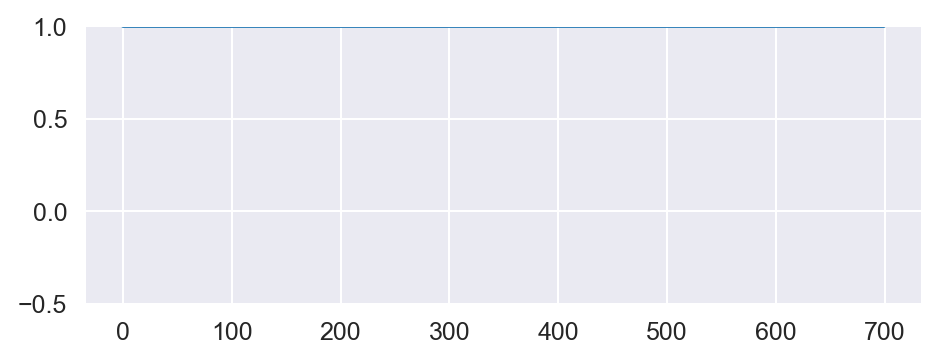

In [717]:
weight = 1
warm_up = None
cooldown = None
n_epochs = 700
xd = []
for i in range(n_epochs):
    wu = i >= warm_up if warm_up is not None else True
    cd = i <= cooldown if cooldown is not None else True
    wt = weight>0 
    xd.append(int(wu&cd&wt))

f,a = plt.subplots(1,1,figsize=(6,2))
a.set_ylim([-.5,1])
a.plot(range(len(xd)), xd)

In [692]:
from torch import optim
model = nn.Sequential(nn.Linear(100, 50), nn.ReLU(), nn.Linear(50, 1))
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
x = torch.randn(1000, 100)
z = model(x)
y = torch.randn(1000, 1)
mse_loss = criterion(y,z)
extra_loss = torch.zeros_like(mse_loss)
total_loss = mse_loss+extra_loss
model.zero_grad()
optimizer.zero_grad()
total_loss.backward()
optimizer.step()

In [694]:
extra_loss

tensor(0.)